<a href="https://colab.research.google.com/github/AndresMontesDeOca/TimeSeries/blob/main/TP1_Ale_.v2ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Demanda electrica horaria, tratamiento para Series Temporales


In [25]:
#Importar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

Importamos la Serie

Como tenemos la serie en el Drive, tenemos que improtar una serie de librerias para poder levantar la serie

No olvidar dar los permisos al archivo para poder leer desde el jpynb el mismo.
Luego, copiamso la ruta al archivo, pero solo nos quedamos con el id para acceder al mismo, a continuacion se copia la ruta completa al archivo

https://drive.google.com/file/d/1cuyeVtIy_DOtiADp5cHwNsucJpzhaBqG/view?usp=share_link


Siempre que tenga que leer un archivo que esta en un drive, copiar esta ruta

In [35]:
# # Code to read csv file into Colaboratory:
# !pip install -U -q PyDrive
# !pip install pandas openpyxl

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Air Pasangers
id = "1LV2t7HpwYpxSumUywyRE1wZ2xyF1KF5I"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('DemHoraria_v2.csv')
dataD = pd.read_csv("DemHoraria_v2.csv", sep=",") # Cargamos el Dataset
data = dataD
##################################################
# Temperature
id = "1Lji7usex9EBPQpTgUhAdI6oRnJN9pAxf"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('SerieT20_2022.csv')
dataT = pd.read_csv("SerieT20_2022.csv") # Cargamos el Dataset

In [32]:
dataT.head()

,Fecha,TempAire
0,1/1/2020 0:00,21.00
1,1/1/2020 1:00,21.00
2,1/1/2020 2:00,20.80
3,1/1/2020 3:00,20.60
4,1/1/2020 4:00,20.60


In [37]:
dataD.head()

,data_hora,Demanda_MW,Vel_viento
0,2015-10-01 02,1032.75,29.90
1,2015-10-01 03,960.61,17.30
2,2015-10-01 04,938.91,8.71
3,2015-10-01 05,943.28,7.25
4,2015-10-01 06,977.78,16.47


In [4]:
# Vamos a suprimir la notacion cientifica
pd.set_option("display.float_format", lambda x:"%.2f" %x)

In [5]:
result=type(data)
print(result)

<class 'pandas.core.frame.DataFrame'>


In [6]:
data.describe()

,Demanda_MW,Vel_viento
count,65535.00,65535.00
mean,2968922103603471429081759744.00,28572930498310260279209885696.00
std,730611400952401882395598389248.00,6903114358998181710542512586752.00
min,-555555.00,0.00
25%,1091.63,8.93
50%,1265.12,15.55
75%,1432.30,26.43
max,186877000000000019090986688839680.00,1763840000000000042999632019587072.00


En base a los valores anteriores, claramente hay datos atipicos en la base, en primer lugar no podemso tener valores negativos de demanda, vemos que el minimo es negativo y el maximo supera el pico de 2242 MW, todo lo que este fuera de este rango, son atipicos

# Preprocesamiento

## Verificacion de Datos Faltantes

In [7]:
# Verificamos el Dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   data_hora   65535 non-null  object 
 1   Demanda_MW  65535 non-null  float64
 2   Vel_viento  65535 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.5+ MB
None


- Se observan 65535 registros
- No se obuservan nulos.

## Eliminamos la tercer columna.
(velocidad del viento, dado que no la vamos a utilizar)

In [8]:
data.drop(columns="Vel_viento", inplace=True)

In [9]:
# Convertimos la columna "data_hora" a tipo de datos de fecha y hora

data["data_hora"]= pd.to_datetime(data["data_hora"], format="%Y-%m-%d %H")

In [10]:
# Renombramos las variables
data.rename(columns={"Demanda_MW": "Demanda", "data_hora":"Fecha"}, inplace=True)

In [11]:
# Seteamos la Fecha como Index
data=data.set_index("Fecha")
display(data.head())

,Demanda
Fecha,
2015-10-01 02:00:00,1032.75
2015-10-01 03:00:00,960.61
2015-10-01 04:00:00,938.91
2015-10-01 05:00:00,943.28
2015-10-01 06:00:00,977.78


## Analisis de Outliers

In [12]:
# Hacemos una descripcion del dataset
display(data.describe())

,Demanda
count,65535.00
mean,2968922103603471429081759744.00
std,730611400952401882395598389248.00
min,-555555.00
25%,1091.63
50%,1265.12
75%,1432.30
max,186877000000000019090986688839680.00


Como ya se indico, es necesario evaluar los valores atipicos, como es una demanda electrica lo que estamos analizando, no es posible tener valores negativos, no tiene sentido fisico. Segun el minimo que figura en el analisis anterior, tenemos valores negativos.
Por otro lado, el pico de demanda maxima en el periodo analizado es 2300MW, por lo tanto, todo valor superior es atipico.

En este periodo tenemos un solo valor "0", el cual es un dato real, fue el corte del 19 de junio de 2019, corte que afecto a Argentina, Brazil y Uruguay, el valor que sigue en minimo es de 83MW.

In [13]:
# En basea a lo antes expuesto, vemos en que fechas tenemos los errores. Cotas establecidas [83, 2300]
display(data.query("Demanda> 2300 or Demanda<83"))


,Demanda
Fecha,
2017-10-19 10:00:00,7691310000000000899886144815104.00
2017-10-19 11:00:00,186877000000000019090986688839680.00
2017-11-16 03:00:00,-555555.00
2017-11-20 03:00:00,-555555.00
2017-11-25 03:00:00,-555555.00
2018-03-20 10:00:00,2265329999999999934464.00
2018-03-20 11:00:00,43041200000000000524288.00
2018-03-20 12:00:00,3020450000000000196608.00
2018-03-21 16:00:00,11326499999999999344640.00


In [14]:
# # Calculamos la mediana general
# median_demand=data["Demanda"][data["Demanda"].between(83, 2300)].median()
# print("Mediana:", median_demand)

Si bien se plantea sustituir los valores extremos por la mediana, no es lo mas conveniente, dado que depende el momento del a;o y la hora donde esta el valor extremo, deberiamos sustituir el valor por el valor en la hora anterior o posterior al valor atipico. De todas formas, como ahora no se como hacerlo, continuo con el procedimiento que hizo Andres

In [15]:
# # Remplazo valores extremos y negativos por la media calculada
# data["Demanda"]= data["Demanda"].apply(lambda x:median_demand if x>2300 or x<83 else x)

Aca en lugar de reemplazar los valores fuera de rango por la Mediana general, primero los ponemos en Null, y luego aplicamos un Back-Fill

In [16]:
# Poniendo en nulos los valores menores a 83 o mayores a 2300
data['Demanda'] = data['Demanda'].apply(lambda x: x if (x >= 83 and x <= 2300) else None)

print('Cantidad de fuera de rango previa:', data.isnull().sum())

# Realizando backfill para llenar los valores nulos/fuera de rabgo
data['Demanda'].fillna(method='backfill', inplace=True)

print('Cantidad de fuera de rango post:', data.isnull().sum())

Cantidad de fuera de rango previa: Demanda    12
dtype: int64
Cantidad de fuera de rango post: Demanda    0
dtype: int64


In [17]:
# Hacemos otro describ para verificar la correccion de los errores
display(data.describe())

,Demanda
count,65535.00
mean,1275.34
std,240.78
min,86.86
25%,1091.63
50%,1265.07
75%,1432.20
max,2237.63


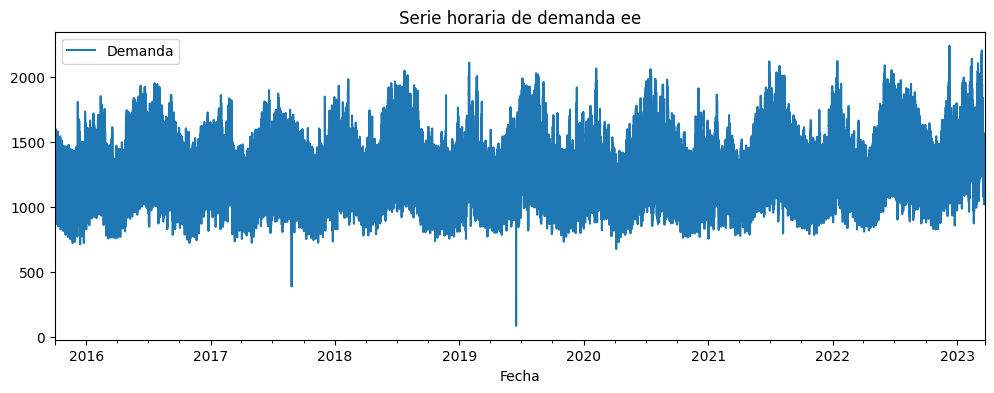

In [18]:
# Ploteamos para ver como queda la serie corregida
data.plot(title="Serie horaria de demanda ee", figsize=(12,4))
plt.show()

- Se siguen observando dos valores muy bajos, segurmente debamos modificar la cota inferior. Confirmarlo con Ale

Decidimos no agregar los valores por dia, y dejarlos atomizados por hora

In [19]:
# # Dado que el corte po rhora es muy atomizado, agregamos por dia
# data_daily=data["Demanda"].resample("D").sum()
# data_daily.plot(title="Serie agregada por Dia de demanda ee", figsize=(12,4))
# plt.show()


In [20]:
# # Seguimos con la variable data
# data=data_daily.to_frame() # Lo paso a Pandas DataFrame, sino me lo tranforma a Pandas Serie (No se porque se hizo este paso)

## Agregacion por dia

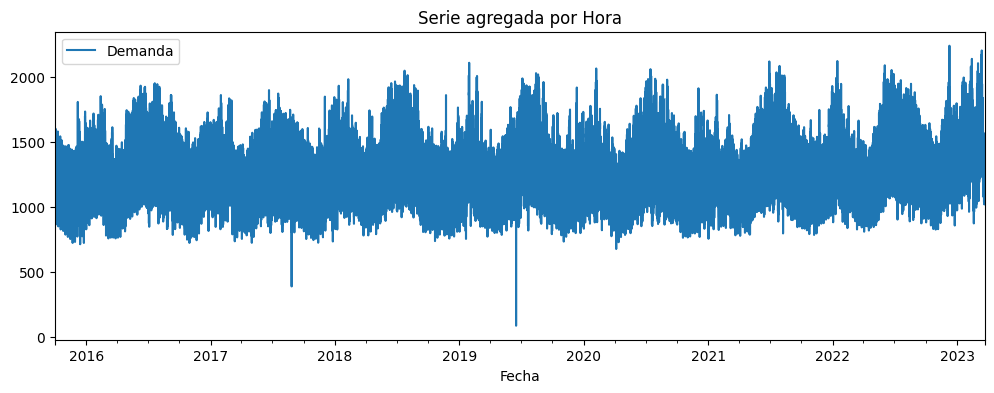

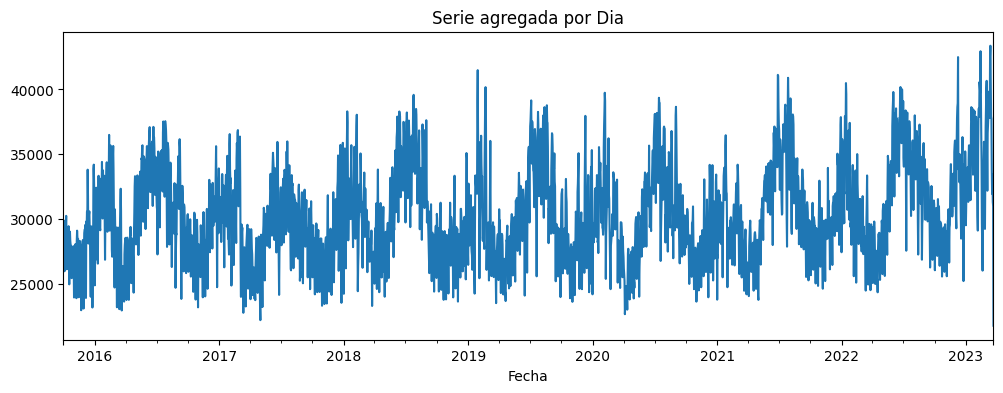

In [21]:
# Tener el corte por hora no tiene mucho sentido para el Analisis
# Ademas, las notebook corren muy lento con tantos datos

# Ploteamos para ver como quedaria la serie corregida
data.plot(title='Serie agregada por Hora', figsize=(12, 4))
plt.show()

# El corte por hora es muy atomizado, agregamos por dia
data_daily = data['Demanda'].resample('D').sum()
data_daily.plot(title='Serie agregada por Dia', figsize=(12, 4))
plt.show()

# Seguimos con la variable data
data = data_daily.to_frame() # Lo paso a Pandas DataFrame, sino me lo transforma a Pandas

# Funciones Auxiliares
(no creo que las usemos)

## Analisis Analitico del Orden de Diferenciacion

In [22]:
# Funciones Auxiliares para en Analsis Analitico de Diferenciacion

from pmdarima.arima import auto_arima, ndiffs, nsdiffs
from pmdarima.arima import ADFTest

def diferenciacion(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con KPSS test(MAIN)')
  print(n_kpss)


  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = ADFTest(alpha=0.05)
  print(adftest.should_diff(y))

ModuleNotFoundError: ignored

## Analisis Analitico de Estacionariedad

In [ ]:
# Funciones Auxiliares para el Analisis Analitco de Estacionariedad
# Mepa que es lo mismo que ADFTest de  pmdarima

from statsmodels.tsa.stattools import adfuller

def estacioneriedad(y):
  resultado = adfuller(y)
  print('Estadistico ADF: %f' % resultado[0])
  print('p-valor: %f' % resultado[1])
  print('Valores criticos:')
  for key, valor in resultado[4].items():
    print('\t%s: %.3f' % (key, valor))

In [ ]:
print_test_afd(data)

# Analisis de la Serie


## 2. Graficar las series originales

In [ ]:
# Ploteamos la serie original

data.plot(figsize=(12, 4))
plt.show()

- Se siguen viendo dos valores atipicos a mediadios del 2017 y del 2019. Habria que revisar las cotas que nos dio el Negocio
- Sigo creyendo que nos conviene acumular los valores por dia en lugar de por hora, no se puede apreciar la serie sino

In [ ]:
# Diferenciacion Analitica de la Serie original

diferenciacion(data)

- Kwiatkowski-Phillips-Schmidt-Shin nos dice que debemos diferenciar una vez
- Agumented Dickey-Fuller y Phillips-Perron nos dicen que no es necesario
- Todavia no tomamos una decision acerca si conviene diferenciar o no

## 3. Graficar la FAS, FAC y FACP

In [ ]:
# Graficamos las Funciones de Autocorrelacion

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF y PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ACF
plot_acf(data['Demanda'], ax=ax1, lags=50)
ax1.set_title('Autocorrelation Function')

# PACF
plot_pacf(data['Demanda'], ax=ax2, lags=50)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

- Del Grafico de Partial-Autocorrelacion (PACF) podemos concluir que la Serie tiene un pico en el lag 1, lo que indica que una Diferenciacion de Orden 1 es recomendable
- Del grarfico Autocorrelacion (ACF) concluimos que la Serie tiene un Trend decreciente, como asi tambien se observan unos valles, lo que indica tambien que la Serie puede tener un componente de Estacionalidad

## 4. Realizar distintas pruebas de raíces unitarias

In [ ]:
# Tests Analiticos de Diferenciacion

# !pip install -q arch
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

kpss_pvalue = kpss(data)[1]
adf_pvalue = adfuller(data)[1]
pp = PhillipsPerron(data)

print('p-values de los distintos test:\n')
print('KPSS (Kwiatkowski-Phillips-Schmidt-Shin)', kpss_pvalue)
print('Dickey-Fuller Aumentada (ADF):', np.round(adf_pvalue, 4), '\n')
print(pp)



- La H0 del test de KPSS indica la estacionariedad, la cual rechazamos con un p-value obtenido del 0.01%
- En cambio los tests de ADF y PP, con ambos p-values casi del 0%, rechazan la H0 de no-estacionariedad
- Los diferentes test nos arrojan valores contradictorios


## 5. Estimaciones con distintos parametros en SARIMA
PENDIENTE


In [ ]:
# Analizamos la descomposicion de la Serie

from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(14, 6))
seasonal_decompose(data['Demanda'], model='additive', period=12).plot()
plt.show()

- Se observa tanto Trend como Estacionalidad, la serie no es Estacionaria
- Es recomendable Diferenciar la serie de alguna manera, antes de aplicar SARIMA